O objetido do projeto é analisar uma base de preços de BicMac e construir um modelo que seja possível projetar o preço através do país e data de projeção.

base: https://www.kaggle.com/datasets/vittoriogiatti/bigmacprice

Import das bibliotecas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import joblib

Import do arquivo

In [ ]:
df = pd.read_csv("BigmacPrice.csv",delimiter=";")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1946 non-null   object 
 1   currency_code  1946 non-null   object 
 2   name           1946 non-null   object 
 3   local_price    1946 non-null   object 
 4   dollar_ex      1946 non-null   int64  
 5   dollar_price   1946 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 91.3+ KB


Temos 6 colunas na base e três colunas vinculadas com o preço: preço do dólar, taxa de conversão do dólar e preço local. Para simplificar vamos trabalhar apenas com a coluna de preço em dólar.

In [ ]:
df = df.drop(columns=['local_price','dollar_ex'])

Vamos analisar a distribuição da variável de preço.

In [ ]:
df['dollar_price'].describe()

count    1946.000000
mean        3.568011
std         1.417054
min         0.000000
25%         2.572500
50%         3.400000
75%         4.240000
max        11.250000
Name: dollar_price, dtype: float64

Temos um valor médio de 3,5 dólares na base, um desvio padrão de 1,4. O mínimo de 0, primeiro quartil de 2,5, mediana de 3,4 e o terceiro quartil de 4,2. O valor máximo ficou em 11,25.

Temos uma distribuição assimétrica com cauda para a direita, vamos confirmar isso através da função skew e da função kurt.

In [ ]:
df['dollar_price'].skew()

0.931765289186794

In [ ]:
df['dollar_price'].kurt()

1.3252545474981923

O valor positivo da função skew indica que os dados são assimétricos à direita, e o valor positivo da função kurt indica que temos outliers mais representativos do que em uma distribuição normal.

[]

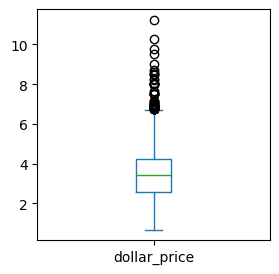

In [ ]:
plt.figure(figsize=(3,3))
df['dollar_price'].plot(kind='box')
plt.plot()

[]

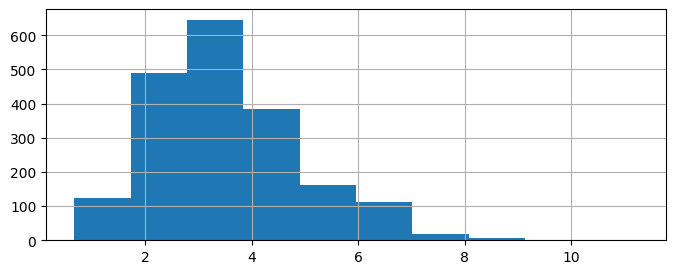

In [ ]:
plt.figure(figsize=(8,3))
df['dollar_price'].hist()
plt.plot()

Os gráficos confirmaram a presença de outliers e a distribuição assimétrica com cauda a direita. Vamos avaliar inicialmente os outliers superiores e em seguida os registros zerados.

In [ ]:
primeiro_quartil = df['dollar_price'].quantile(0.25)
terceiro_quartil = df['dollar_price'].quantile(0.75)

intervalo_interquartilico = terceiro_quartil - primeiro_quartil
limite_superior = terceiro_quartil + (intervalo_interquartilico * 1.5)
limite_inferior = primeiro_quartil - (intervalo_interquartilico * 1.5)

print("limite superior: ", limite_superior)
print("limite inferior: ", limite_inferior)
print("----------------------------------")
print("Total de registros: ", df.shape[0])

print("Quantidade de registros acima do limite superior: ", df[df['dollar_price'] > limite_superior].shape[0])
print("Quantidade de registros abaixo do limite inferior: ", df[df['dollar_price'] < limite_inferior].shape[0])

limite superior:  6.73
limite inferior:  0.08999999999999986
----------------------------------
Total de registros:  1945
Quantidade de registros acima do limite superior:  58
Quantidade de registros abaixo do limite inferior:  0


Pelo intervalo interquartilico consideramos como outliers preços acima de 6,7 e abaixo de 0,7 dolares. Abaixo temos apenas um registro, vamos avaliá-lo.

In [ ]:
df[df['dollar_price'] < limite_inferior]

,date,currency_code,name,dollar_price


Como é apenas um único registro iremos exclui-lo.

In [ ]:
df = df[df['dollar_price'] > limite_inferior]

Agora vamos avaliar os outliers superiores.

In [ ]:
df[df['dollar_price'] > limite_superior]

,date,currency_code,name,dollar_price
254,01/05/2006,NOK,Norway,7.17
295,01/01/2007,NOK,Norway,6.92
318,01/06/2007,BRL,Brazil,6.90
336,01/06/2007,NOK,Norway,8.00
359,01/06/2008,BRL,Brazil,7.50
367,01/06/2008,DKK,Denmark,7.00
377,01/06/2008,NOK,Norway,8.00
388,01/06/2008,SEK,Sweden,7.60
399,01/07/2009,BRL,Brazil,8.03
440,01/01/2010,BRL,Brazil,8.20


Apesar dos registros serem outliers vemos nitidamente que são casos reais e não fruto de algum problema de dado. Por este motivo inicialmente vamos mante-los na base.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1945 entries, 0 to 1945
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1945 non-null   object 
 1   currency_code  1945 non-null   object 
 2   name           1945 non-null   object 
 3   dollar_price   1945 non-null   float64
dtypes: float64(1), object(3)
memory usage: 76.0+ KB


Precisamos tratar os campos de data, tipo de moeda e nome do país antes da construção do modelo. Vamos iniciar tratando a variável de dia, vamos transformá-la em um campo numérico, no qual o primeiro dia será o 0 e iremos acrescentando em uma unidade. Isso permitirá que o modelo consiga entender padrões lineares ao longo do tempo.

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['date'].value_counts()

<ipython-input-38-3e54dcbcc698>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['date'] = pd.to_datetime(df['date'])


2022-01-01    73
2021-01-07    73
2018-01-07    72
2019-01-01    72
2021-01-01    72
2020-01-07    72
2020-01-14    72
2019-09-07    72
2022-01-07    70
2014-01-07    57
2014-01-01    56
2017-01-07    56
2017-01-01    56
2016-01-07    56
2016-01-01    56
2015-01-07    56
2015-01-01    56
2018-01-01    55
2013-01-07    55
2012-01-01    55
2011-01-07    55
2013-01-01    55
2012-01-07    53
2007-01-06    41
2010-01-07    41
2010-01-01    41
2009-01-07    41
2007-01-01    41
2006-01-05    41
2005-01-06    41
2008-01-06    40
2004-01-05    40
2002-01-04    33
2006-01-01    32
2003-01-04    32
2001-01-04    28
2000-01-04    28
Name: date, dtype: int64

In [ ]:
df2 = df.copy()

In [ ]:
df2 = df2.sort_values(by=['date'])
df2['date'] = pd.to_datetime(df2['date'])
df2['data_numerica'] = (df2['date'] - df2['date'].min()).dt.days
df2[['date','data_numerica']].tail(100)

,date,data_numerica
1812,2022-01-01,8033
1811,2022-01-01,8033
1810,2022-01-01,8033
1809,2022-01-01,8033
1808,2022-01-01,8033
...,...,...
1896,2022-01-07,8039
1895,2022-01-07,8039
1894,2022-01-07,8039
1900,2022-01-07,8039


Agora vamos excluir o campo de data do nosso df

In [ ]:
df2 = df2.drop(columns=['date'])
df2

,currency_code,name,dollar_price,data_numerica
0,ARS,Argentina,2.50,0
27,USD,United States,2.24,0
26,THB,Thailand,1.45,0
25,TWD,Taiwan,2.33,0
24,CHF,Switzerland,5.90,0
...,...,...,...,...
1896,EUR,Germany,4.58,8039
1895,EUR,France,4.70,8039
1894,EUR,Finland,5.25,8039
1900,HKD,Hong Kong,3.00,8039


Vamos analisar as duas últimas variáveis que dizem respeito ao tipo de moeda e aos paises

In [ ]:
df2

,currency_code,name,dollar_price,data_numerica
0,ARS,Argentina,2.50,0
27,USD,United States,2.24,0
26,THB,Thailand,1.45,0
25,TWD,Taiwan,2.33,0
24,CHF,Switzerland,5.90,0
...,...,...,...,...
1896,EUR,Germany,4.58,8039
1895,EUR,France,4.70,8039
1894,EUR,Finland,5.25,8039
1900,HKD,Hong Kong,3.00,8039


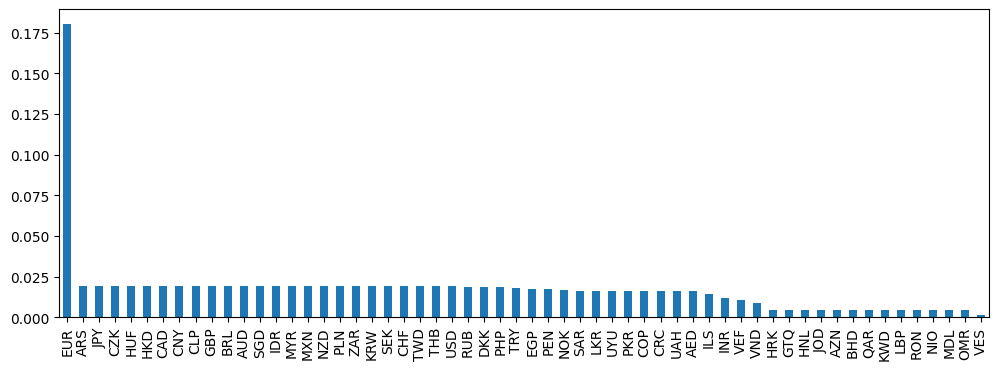

In [ ]:
plt.figure(figsize=(12,4))
df2['currency_code'].value_counts(normalize=True).plot(kind='bar')
plt.show()

A maior frequência de moeda é o euro, o que nos sugere que há uma maior proporção de países europeus na base, vamos confirmar isso:

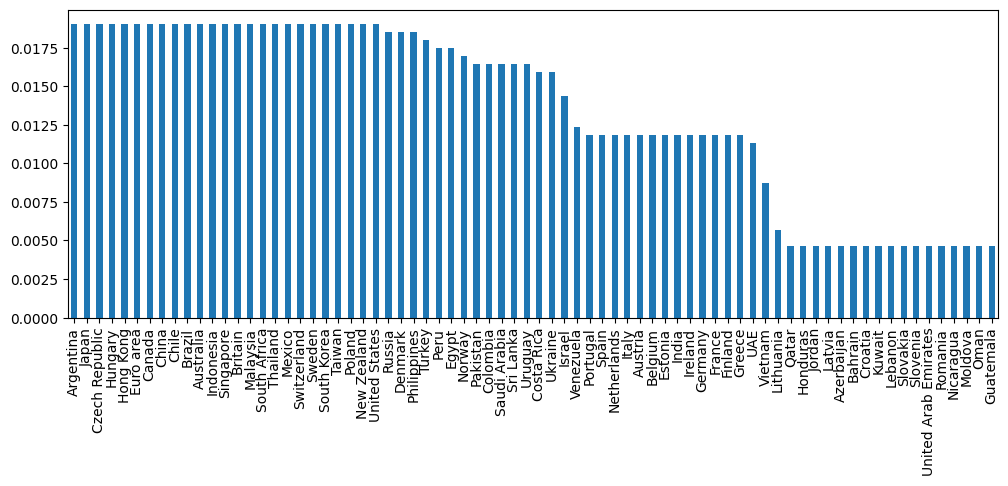

In [ ]:
plt.figure(figsize=(12,4))
df2['name'].value_counts(normalize=True).plot(kind='bar')
plt.show()

Realmente notamos vários países da Europa na base, alguns fora da zona do euro, mas outros que são aderentes ao grupo possuem bastante relevância na base.

O último passo antes de construirmos o modelo é transformar as variáveis categóricas em dummies para facilitar o aprendizado do modelo.

In [ ]:
dummy_moeda = pd.get_dummies(df2['currency_code'])
df2 = pd.concat([dummy_moeda,df2],axis=1)

dummy_pais = pd.get_dummies(df2['name'])
df2 = pd.concat([dummy_pais,df2],axis=1)

df2.drop(columns=['currency_code','name'],inplace=True)
df2.columns.to_list()

['Argentina',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahrain',
 'Belgium',
 'Brazil',
 'Britain',
 'Canada',
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Croatia',
 'Czech Republic',
 'Denmark',
 'Egypt',
 'Estonia',
 'Euro area',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Guatemala',
 'Honduras',
 'Hong Kong',
 'Hungary',
 'India',
 'Indonesia',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Jordan',
 'Kuwait',
 'Latvia',
 'Lebanon',
 'Lithuania',
 'Malaysia',
 'Mexico',
 'Moldova',
 'Netherlands',
 'New Zealand',
 'Nicaragua',
 'Norway',
 'Oman',
 'Pakistan',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Qatar',
 'Romania',
 'Russia',
 'Saudi Arabia',
 'Singapore',
 'Slovakia',
 'Slovenia',
 'South Africa',
 'South Korea',
 'Spain',
 'Sri Lanka',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Thailand',
 'Turkey',
 'UAE',
 'Ukraine',
 'United Arab Emirates',
 'United States',
 'Uruguay',
 'Venezuela',
 'Vietnam',
 'AED',
 'ARS',
 'AUD',
 'AZN',
 'BHD',
 'BRL',
 'CAD',
 'CHF

Agora vamos dividir a base em treino e teste mas de uma forma que a gente consiga manter a mesma distribuição de valores em ambas as bases para não atrapalhar na performance do modelo.

In [ ]:
df2 = df2[df2['dollar_price']> 0]

In [ ]:
df2['cat_preco'] = pd.cut(df2['dollar_price'],bins=[0.1,2,3.5,4.5,6.,np.inf],labels=[1,2,3,4,5])
df2 = df2.reset_index(drop=True)

In [ ]:
df2['cat_preco'].unique()

[2, 1, 4, 3, 5]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [ ]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

for train_index,test_index in split.split(df2,df2['cat_preco']):
  strat_train = df2.loc[train_index]
  strat_test = df2.loc[test_index]

Removendo a coluna de categoria

In [ ]:
for set_ in (strat_train, strat_test):
  set_.drop("cat_preco",axis=1,inplace=True)

Antes de criarmos o modelo vamos normalizar os dados através do MinMaxScaler.

In [ ]:
scaler = MinMaxScaler()
y_train = strat_train['dollar_price']
X_train = strat_train.drop(columns=['dollar_price'])
X_train_scaled = scaler.fit_transform(X_train)

y_test = strat_test['dollar_price']
X_test = strat_test.drop(columns=['dollar_price'])
X_test_scaled = scaler.transform(X_test)

Vamos iniciar o nosso primeiro modelo

In [ ]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

#calculando as métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#guardando as métricas em um DataFrame
metrics = pd.DataFrame({'Model': ['Linear Regression'],
                        'MSE': [mse],
                        'RMSE': [rmse],
                        'MAE': [mae],
                        'R2': [r2]})

In [ ]:
metrics

,Model,MSE,RMSE,MAE,R2
0,Linear Regression,0.466581,0.683067,0.438624,0.763921


Nada mal para um primeiro modelo, tivemos um r² de 0.76, o que significa que o nosso modelo consegue explicar 76% da variação dos dados. E também tivemos um RMSE de 0.68, ou seja, o desvio padrão dos erros do modelo gira em torno deste valor.

Vamos tentar um modelo mais robusto

In [ ]:
tree_reg = DecisionTreeRegressor(random_state=42)

#realizando a validação cruzada k-fold
scores = cross_val_score(tree_reg, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=10)
tree_reg_rmse_scores = np.sqrt(-scores)

#ajustando o modelo aos dados de treinamento
tree_reg.fit(X_train_scaled, y_train)

#fazendo previsões no conjunto de teste
y_pred = tree_reg.predict(X_test_scaled)

#calculando as métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#incluindo a nova linha no df
nova_linha = {'Model': 'Decision Tree Regressor', 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
metrics = metrics.append(nova_linha , ignore_index=True)

def display_scores(scores):
    print("Scores: ", [round(score, 3) for score in scores])
    print("Mean: ", round(scores.mean(), 3))
    print("Standard deviation: ", round(scores.std(), 3))

display_scores(tree_reg_rmse_scores)

Scores:  [0.47, 0.637, 0.621, 0.516, 0.453, 0.373, 0.487, 0.71, 0.487, 0.735]
Mean:  0.549
Standard deviation:  0.113


<ipython-input-54-4f701c8c51dc>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(nova_linha , ignore_index=True)


Treinamos um modelo de Decision Tree Regressor e verificamos o desempenho através de validação cruzada com k-folds, para termos certeza que o nosso modelo não sofreu overfitting. Como podemos ver tivemos um desvio padrão razoavelmente baixo de 0.113 e uma média de RMSE em torno de 0.55, vamos ver se este valor ficou próximo do que obtivemos na base de teste.

In [ ]:
metrics

,Model,MSE,RMSE,MAE,R2
0,Linear Regression,0.466581,0.683067,0.438624,0.763921
1,Decision Tree Regressor,0.282972,0.531951,0.259177,0.856822


Obtivemos 0.53 de RMSE na base de teste, o que é um excelente sinal que o nosso modelo não sofreu overfitting já que essa métrica ficou bem próxima do que obtivemos na conjunto de validação da base de treino. Além disso, o nosso r² melhorou e agora conseguimos explicar 85% da variação dos nosso dados.

Já temos um bom modelo mas vamos tentar melhor o resultado otimizando os hiperparametros com grid search.

In [ ]:
#definindo os hiperparametros
params = {'max_depth': list(range(1, 11)),
          'min_samples_split': [0.001, 0.01, 0.1, 0.2, 0.3],
          'min_samples_leaf': [0.001, 0.01, 0.1, 0.2, 0.3]}

#criando o objeto
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), params, cv=5, scoring='neg_mean_squared_error')

#ajustando dados de treinamento
grid_search.fit(X_train_scaled, y_train)

#melhores parâmetros
print("Best parameters:", grid_search.best_params_)

#melhor pontuação (neg_mean_squared_error)
print("Best score:", np.sqrt(-grid_search.best_score_))

#ajustando o modelo com os melhores parâmetros encontrados
best_model = grid_search.best_estimator_

#ralizar a previsão
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

#calcular o RMSE para o conjunto de treinamento e teste
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

#calculando as métricas
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

#incluindo a nova linha no df
nova_linha = {'Model': 'Decision Tree Regressor Otimizado com GridSearch', 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
metrics = metrics.append(nova_linha , ignore_index=True)

#pontuações
print("RMSE - Train: ", rmse_train)
print("RMSE - Test: ", rmse_test)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 0.001, 'min_samples_split': 0.01}
Best score: 0.9692924979223263
RMSE - Train:  0.8989158453328601
RMSE - Test:  0.936458528954723


<ipython-input-56-20aa7498e95a>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(nova_linha , ignore_index=True)


In [ ]:
metrics

,Model,MSE,RMSE,MAE,R2
0,Linear Regression,0.466581,0.683067,0.438624,0.763921
1,Decision Tree Regressor,0.282972,0.531951,0.259177,0.856822
2,Decision Tree Regressor Otimizado com GridSearch,0.876955,0.936459,0.735154,0.556281


O desempenho sem o grid search foi melhor em todas as métricas, vamos tentar outro modelo, o Random Forest.

In [ ]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train_scaled, y_train)

#validação cruzada com K-folds
forest_scores = cross_val_score(forest_reg, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

#exibição das métricas
display_scores(forest_rmse_scores)

#predição no conjunto de teste
forest_pred = forest_reg.predict(X_test_scaled)

#calculo das métricas
forest_mse = mean_squared_error(y_test, forest_pred)
forest_rmse = np.sqrt(forest_mse)
forest_mae = mean_absolute_error(y_test, forest_pred)
forest_r2 = r2_score(y_test, forest_pred)

#adição das métricas ao dataframe
nova_linha = {'Model': 'Random Forest Regressor', 'MSE': forest_mse, 'RMSE': forest_rmse, 'MAE': forest_mae, 'R2': forest_r2}
metrics = metrics.append(nova_linha , ignore_index=True)

Scores:  [0.369, 0.565, 0.442, 0.433, 0.333, 0.308, 0.433, 0.489, 0.367, 0.64]
Mean:  0.438
Standard deviation:  0.099


<ipython-input-58-20aff58215b5>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(nova_linha , ignore_index=True)


In [ ]:
metrics

,Model,MSE,RMSE,MAE,R2
0,Linear Regression,0.466581,0.683067,0.438624,0.763921
1,Decision Tree Regressor,0.282972,0.531951,0.259177,0.856822
2,Decision Tree Regressor Otimizado com GridSearch,0.876955,0.936459,0.735154,0.556281
3,Random Forest Regressor,0.178042,0.421950,0.231427,0.909915


Foi o nosso melhor modelo até agora com um r² de 0,91 e um RMSE de 0,42 .Vamos tentar o Random Forest otimizado com GridSearch.

In [ ]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train_scaled, y_train)

#exibindo os melhores parâmetros e o melhor score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", np.sqrt(-grid_search.best_score_))

#predição no conjunto de teste com o melhor modelo
forest_best = grid_search.best_estimator_
forest_pred = forest_best.predict(X_test_scaled)

#calculo das métricas
forest_mse = mean_squared_error(y_test, forest_pred)
forest_rmse = np.sqrt(forest_mse)
forest_mae = mean_absolute_error(y_test, forest_pred)
forest_r2 = r2_score(y_test, forest_pred)

#adição das métricas ao dataframe
nova_linha = {'Model': 'Random Forest Regressor - Grid Search', 'MSE': forest_mse, 'RMSE': forest_rmse, 'MAE': forest_mae, 'R2': forest_r2}
metrics = metrics.append(nova_linha , ignore_index=True)

Best parameters:  {'max_features': 6, 'n_estimators': 30}
Best score:  0.49722677493093626


<ipython-input-60-fe51e0318380>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(nova_linha , ignore_index=True)


In [ ]:
metrics

,Model,MSE,RMSE,MAE,R2
0,Linear Regression,0.466581,0.683067,0.438624,0.763921
1,Decision Tree Regressor,0.282972,0.531951,0.259177,0.856822
2,Decision Tree Regressor Otimizado com GridSearch,0.876955,0.936459,0.735154,0.556281
3,Random Forest Regressor,0.178042,0.421950,0.231427,0.909915
4,Random Forest Regressor - Grid Search,0.162209,0.402751,0.214237,0.917926


Melhoramos apenas um pouco as métricas mas de todos foi o nosso melhor modelo com um r² de 0,92 e um RMSE de 0,4 , bem próximo do 0,49 que obtivemos na base de validação, o que indica que o modelo está com um desempenho consistente.

In [ ]:
#salvando o modelo
joblib.dump(forest_best, 'model.pkl')

['model.pkl']

In [ ]:
#salvando o normalizador do MinMaxScaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']